<h1> Pesquisa em bancos de dados para astronomia</h1>

Primeiramente e necessário que o usuário tenha instalado no seu computador os módulos: numpy, pandas, astroquery, astropy, seaborn e matplotlib. O módulo Astrofunctions é um documento .py , criado pelo Rafael, que precisa estar alocado no mesmo diretório que o código sera colocado.
Para instalacao dos módulos extras e necessário abrir o Terminal e digitar o comando pip install O_nome_do_modulo_de_interesse. O comando é o mesmo para usuários do mac e para usuários da distribuição do anaconda no windows.  

In [5]:
import numpy as np
import pandas as pd
from astroquery.ned import Ned
from astroquery.simbad import Simbad
from astropy.table import Table,QTable
import astropy.units as u
from astropy import coordinates
import AstroFunctions as astro
import seaborn as sns
import matplotlib.pyplot as plt

Utilizando o módulo Pandas, o próximo passo é ler um arquivo csv alocado no endereço entre 
(""). Apos a leitura desse arquivo, o comando vvds[].values serve apara alocar em uma array 
os valores contidos na coluna intitulada "RA".

In [7]:
vvds = pd.read_csv("vvds-not.csv")
RA = vvds["RA"].values
DEC = vvds["DEC"].values

Para que seja possível percorrer varias regiões relacionadas aos vários valores contidos na coluna que descreve as coordenadas e necessário realizar a pesquisa com o auxilio de um for que percorre todas as linhas das arrays e pesquisa regiao por região.

In [9]:
co = coordinates.SkyCoord(ra = RA[0],dec= DEC[0],unit=(u.deg,u.deg))
#Pesquisa no banco de dados NED
Ned_table = Ned.query_region(co, radius=0.1 * u.deg)
#Pesquisa no banco de dados SIMBAD
Simbad_table = Simbad.query_region(co, radius=0.1 * u.deg)

In [12]:
Ned_table[3]

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
4,VVDS 020086359,36.58056,-4.82029,VisS,--,--,,24.9R,5.917,2,0,0,2,0,0,0


In [13]:
Simbad_table[]

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
VIDEO J022643.59-044924.68,02 26 43.60,-04 49 24.7,6,6,--,--,0,C,N,2013MNRAS.428.1281J


Com relação ao astroquery, ele possui um tempo limite de conexão com o servidor que é pequeno, por isso para uma pesquisa de muitos dados é necessário alterar o valor da variável timeout na pasta em que o módulo astroquery foi instalado e na respectiva pasta do banco de dados utilizado.

In [8]:
l1 = []
l2 = []
for i in range(10):
    co = coordinates.SkyCoord(ra = RA[i],dec= DEC[i],unit=(u.deg,u.deg))
    #Pesquisa no banco de dados NED
    ned_table = Ned.query_region(co, radius=0.1* u.deg) 
    df = ned_table.to_pandas()
    l1.append(df)
    #Pesquisa no banco de dados SIMBAD
    simbad_table = Simbad.query_region(co, radius=0.1* u.deg) 
    df = simbad_table.to_pandas()
    l2.append(df)
ned = pd.concat(l1, axis = 0, ignore_index = True)    
simbad = pd.concat(l2, axis=0, ignore_index = True)

In [9]:
coluna_simbad = simbad["RA"].values


In [63]:
print(len(coluna_simbad))
print(len(coluna_simbad[1919].split()))


41936
2


In [67]:

def hmstodegree(array):
    """ Função que converte uma array com coordenadas em unidades de tempo que normalmente
    caracterizam uma Ascenção Reta(RA)para grau decimal
    input = array com dados do tipo strings onde horas, minutos e segundos estão separados por
    um espaço
    output = array com dados do tipo float em graus decimais"""
    array_graus = []
    for i in range(len(array)):
        hms = array[i].split()
        if len(hms) == 2:
            hms.append(0)
        h = float(hms[0])
        m = float(hms[1])
        s = float(hms[2])
        graus = h*15 + m*(15/60) + s*(15/3600)
        array_graus.append(graus)
    return array_graus

In [69]:
coluna_simbad_graus = hmstodegree(coluna_simbad)
len(coluna_simbad_graus)

41936

In [ ]:
def dmstodegree(array):
    """ Função que converte uma array com coordenadas em unidades angulares que normalmente
    caracterizam uma Declinação(DEC) para grau decimal
    input = array com dados do tipo strings onde graus, minutos e segundos estão separados por
    um espaço
    output = array com dados do tipo float em graus decimais"""
    array_graus = []
    for i in range(len(array)):
        hms = array[i].split()
        if len(hms) == 2:
            hms.append(0)
        d = float(hms[0])
        m = float(hms[1])
        s = float(hms[2])
        graus = d + m*(1/60) + s*(1/3600)
        array_graus.append(graus)
    return array_graus

Para aplicar duas tabelas na função que realiza o cross match, é necessário que se converta a tabela em formato pandas para uma tabela em formato astropy, conversão mostrada abaixo:

In [14]:
ned_table = Table.from_pandas(ned)
simbad_table = Table.from_pandas(simbad)
type(ned_table)
type(simbad_table)

astropy.table.table.Table

In [7]:
error = 0.00028
data = astro.match(ned_table, simbad_table,'RA','RA','DEC','DEC',error)
if len(data) != 0:
    data.add_column(1.5, name = 'random')
    for i in range(0, len(data)):
        data[i]['random'] = np.random.random()

ValueError: could not convert string to float: '02 26 43.08'

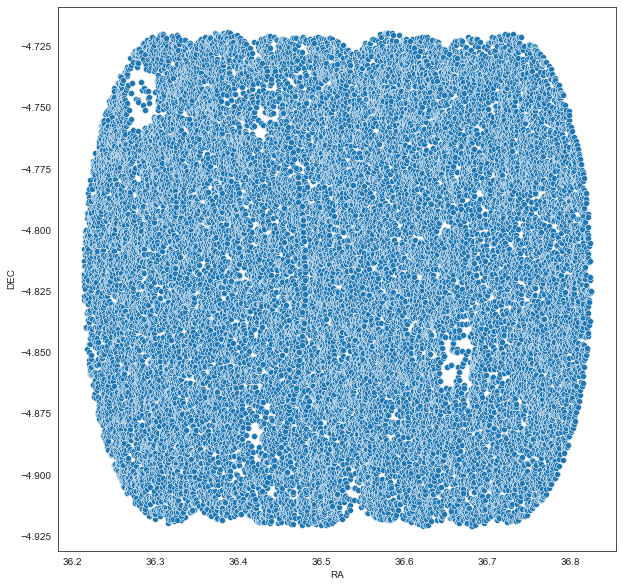

In [15]:
# Criando o ambiente do gráfico 
sns.set_style("white")
plt.figure(figsize=(10, 10))

# Gráfico de Dispersão
RA_DEC_Ned = ned_table["RA","DEC"]
Ned_pandas = RA_DEC_Ned.to_pandas()
g = sns.scatterplot(x = "RA", y = "DEC", data= Ned_pandas)

plt.show()

In [14]:
Ned_table["RA","DEC"]

RA,DEC
degrees,degrees
float64,float64
36.57948,-4.82312
36.57974,-4.81113
36.58008,-4.80914
36.58056,-4.82029
36.58058,-4.83664
36.58068,-4.83091
36.58095,-4.82493
36.58095,-4.83048
